1. Upload zip file signs.zip to 'My Drive' 
2. Mount your drive using code below. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import nonechucks as nc

import numpy as np


nonechucks may not work properly with this version of PyTorch (1.3.1). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [2]:
#using pretrained model RESNET, source: https://pytorch.org/hub/pytorch_vision_resnet/
model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)

Using cache found in C:\Users\Ahmad/.cache\torch\hub\pytorch_vision_v0.4.2


In [2]:
data_dir = 'signs' # Directory of your unzipped "signs" folder

batch_size = 64

# mean and std values are specified in https://pytorch.org/hub/pytorch_vision_resnet/
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std)])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

train_data = nc.SafeDataset(train_data)
test_data = nc.SafeDataset(test_data)
valid_data = nc.SafeDataset(valid_data)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

train_on_gpu = torch.cuda.is_available()

classes = ['dog','dragon','goat','horse', 'monkey', 'ox', 'pig', 'rabbit', 'ratt', 'rooster', 'snake', 'tiger']

________________________________

In [3]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plot = plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

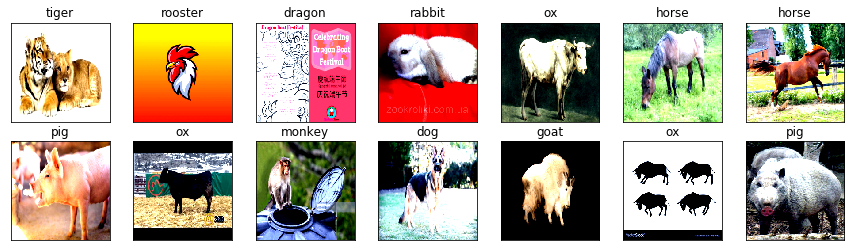

In [4]:
# displaying random images

with torch.no_grad():
    dataiter = iter(testloader)
    test_images, test_labels = dataiter.next()
    test_images.numpy()

fig = plt.figure(figsize=(15, 4))
for idx in np.arange(14):
    ax = fig.add_subplot(2, 14/2, idx+1, xticks=[], yticks=[])
    imshow(test_images.cpu()[idx])
    ax.set_title("{}".format(classes[test_labels[idx]]))

In [8]:
print(image.shape)
print('training on ' + ('GPU' if train_on_gpu else 'CPU'))

torch.Size([3, 224, 224])
training on GPU


In [9]:
####################
# Making The Model #
####################

# Stop tracking gradients to keep the parameters as it is
for param in model.parameters():
    param.require_grad = False

# edit fc "the last layer in the model" to suit our needs
#the layer has 512 input features
model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 12),
                                 nn.LogSoftmax(dim=1))

if train_on_gpu:
    model.cuda()

In [10]:
###########################
# Criterion And Optimizer #
###########################

import torch.optim as optim
# Loss function chosen based on log soft max layer in the model
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [13]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_animals.pt')
        valid_loss_min = valid_loss

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
Epoch: 1 	Training Loss: 1.833291 	Validation Loss: 0.999501
Validation loss decreased (inf --> 0.999501).  Saving model ...
Epoch: 2 	Training Loss: 0.778005 	Validation Loss: 0.485780
Validation loss decreased (0.999501 --> 0.485780).  Saving model ...
Epoch: 3 	Training Loss: 0.470018 	Validation Loss: 0.313578
Validation loss decreased (0.485780 --> 0.313578).  Saving model ...
Epoch: 4 	Training Loss: 0.336483 	Validation Loss: 0.218810
Validation loss decreased (0.313578 --> 0.218810).  Saving model ...
Epoch: 5 	Training Loss: 0.249146 	Validation Loss: 0.147065
Validation loss decreased 

In [11]:
model.load_state_dict(torch.load('Trained_model.pt'))

<All keys matched successfully>

In [12]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, predection = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = predection.eq(target.data.view_as(predection))
    # convert the output into a numpy array
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(12):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Test Loss: 0.218897

Test Accuracy of   dog: 94% (52/55)
Test Accuracy of dragon: 90% (50/55)
Test Accuracy of  goat: 85% (47/55)
Test Accuracy of horse: 98% (54/55)
Test Accuracy of monkey: 92% (51/55)
Test Accuracy of    ox: 87% (48/55)
Test Accuracy of   pig: 94% (52/55)
Test Accuracy of rabbit: 96% (53/55)
Test Accuracy of  ratt: 94% (52/55)
Test Accuracy of rooster: 96% (53/55)
Test Accuracy of snake: 96% (53/55)
Test Accuracy of tiger: 94% (52/55)

Test Accuracy (Overall): 93% (617/660)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

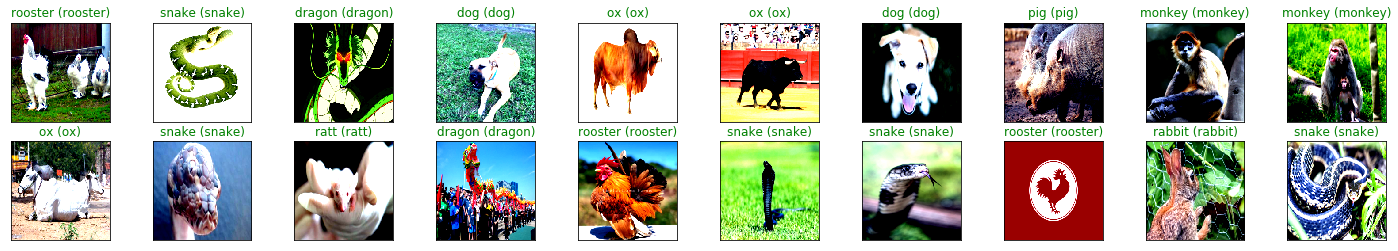

In [13]:
# obtain one batch of test images
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    images.numpy()

    if train_on_gpu:
        images = images.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, predection = torch.max(output, 1)
    # conver the predection tensor into a numpy array
    predection = predection.cpu().numpy() if train_on_gpu else predection.numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(images.cpu()[idx])
        ax.set_title("{} ({})".format(classes[predection[idx]], classes[labels[idx]]),
                    color=("green" if predection[idx]==labels[idx].item() else "red"))